<a href="https://colab.research.google.com/github/MRS-NIH/DeepJPRESS/blob/main/deepJPRESS_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Click **Run all** to reproduce in vivo test results.
This notebook will automatically download pretrained model parameters and in vivo test datasets from the repository on nitrc:
https://www.nitrc.org/frs/download.php/17158/fingerprint_model.h5 and
https://www.nitrc.org/frs/download.php/18526/numpy_data.npz

In [ ]:
# This cell creates a Python 3.9 and TensorFlow 2.15 environment, on which deepJPRESS was developed. It takes about 2 minutes.
import subprocess
commands = [
    "pip install -q condacolab",
    "python -c 'import condacolab; condacolab.install()'"
]

for cmd in commands:
    print(f"Running: {cmd}")
    try:
        subprocess.run(cmd, shell=True, check=True);
    except subprocess.CalledProcessError as e:
        print(f"⚠️ Ignored error: {e}")

!conda create -q -n py39 python=3.9 -y
!conda run -n py39 pip install tensorflow[and-cuda]==2.15.1

Running: pip install -q condacolab
Running: python -c 'import condacolab; condacolab.install()'
⚠️ Ignored error: Command 'python -c 'import condacolab; condacolab.install()'' returned non-zero exit status 1.
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/py39

  added / updated specs:
    - python=3.9


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge 
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu 
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h4bc722e_7 
  ca-certificates    conda-forge/noarch::ca-certificates-2025.8.3-hbd8a1cb_0 
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.44-h1423503_1 
  libexpat           conda-forge/linux-64::libexpat-2.7.1-hecca717_0 
  libffi             conda-forge/linux-64::libffi-3.4.6-h2dba641_1 
  libgcc             conda-forge/linux-64::libg

In [ ]:
import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, fftshift, ifft
from scipy.optimize import curve_fit
from glob import glob
import random
from tqdm.notebook import tqdm
from urllib.request import urlretrieve
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download the in vivo data and the model weights from nitrc
urlretrieve('https://www.nitrc.org/frs/download.php/18526/numpy_data.npz', 'numpy_data.npz')
urlretrieve('https://www.nitrc.org/frs/download.php/17158/fingerprint_model.h5', 'fingerprint_model.h5')

('fingerprint_model.h5', <http.client.HTTPMessage at 0x7fa668352e10>)

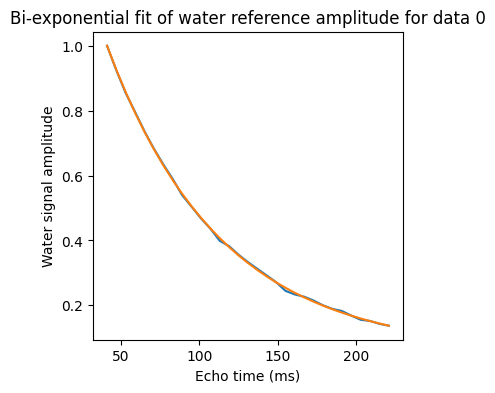

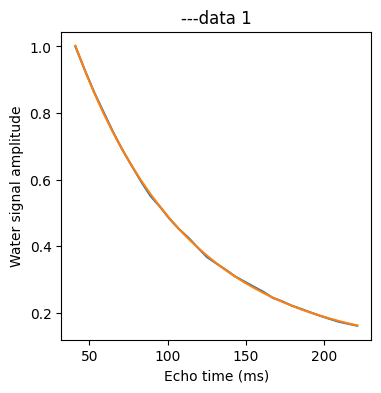

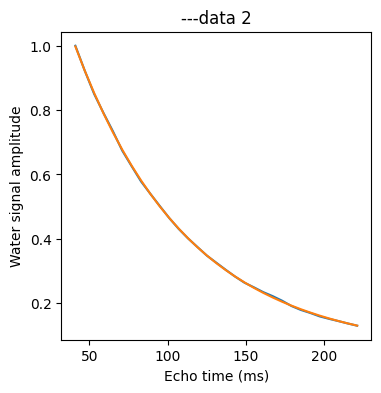

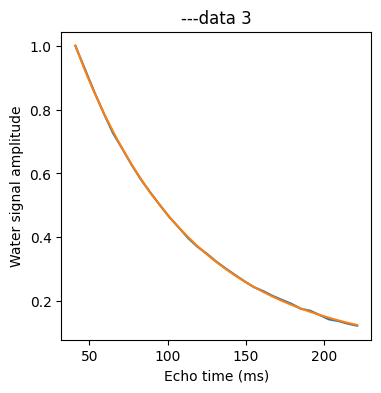

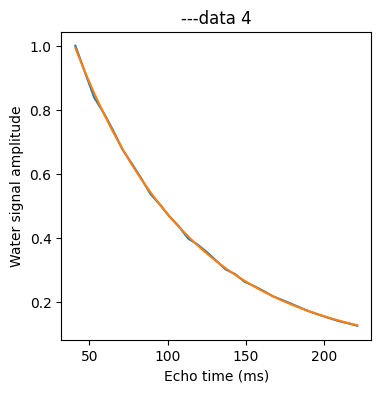

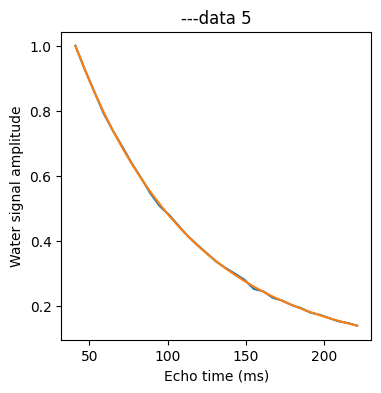

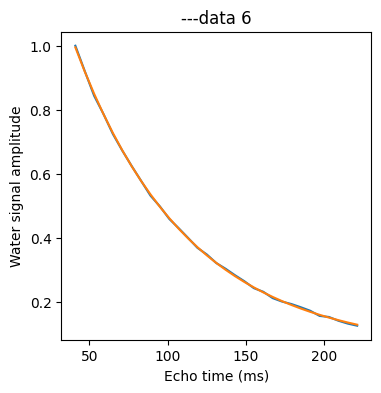

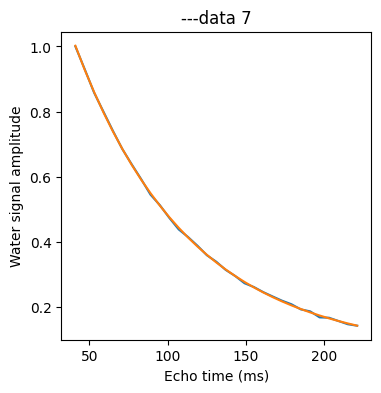

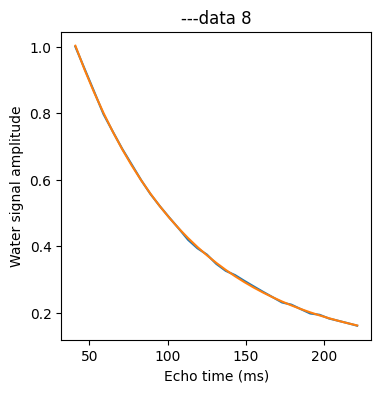

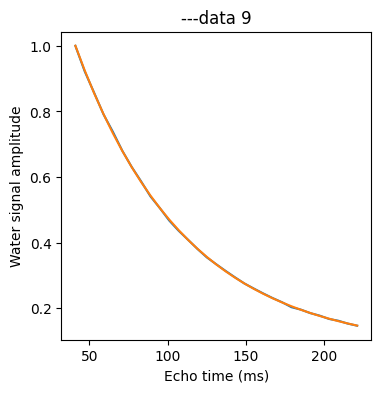

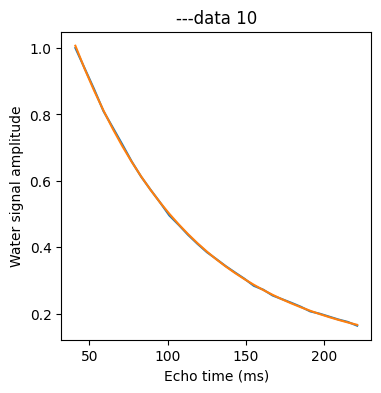

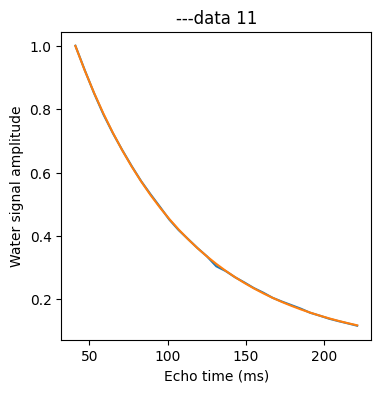

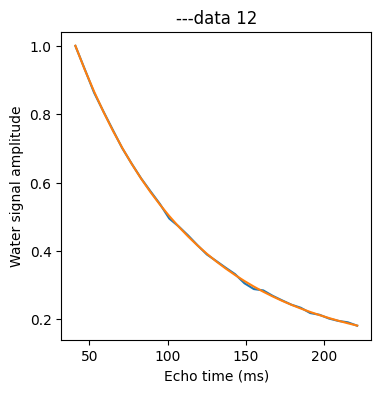

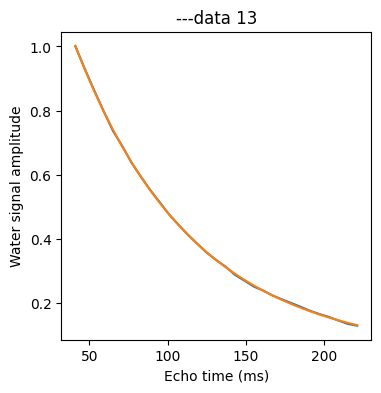

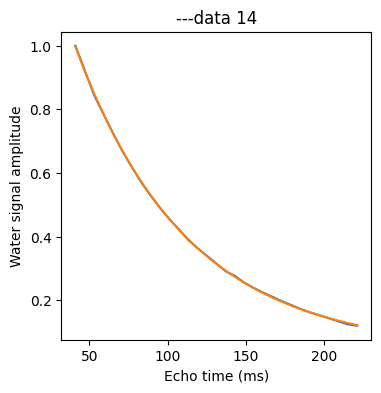

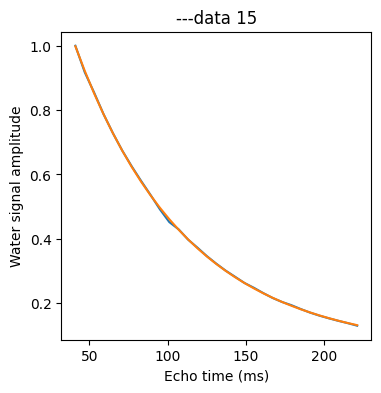

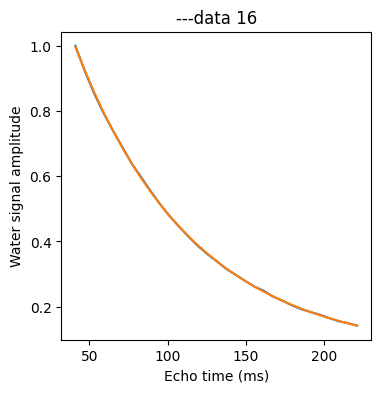

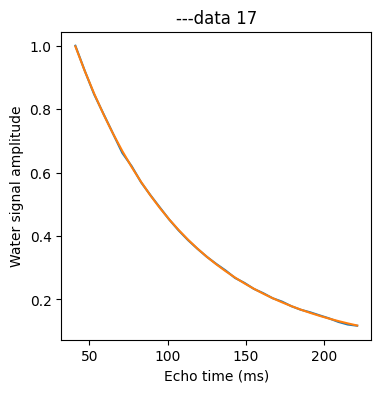

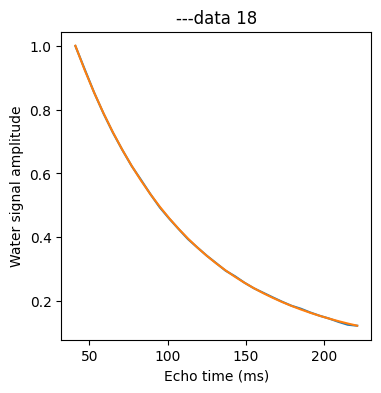

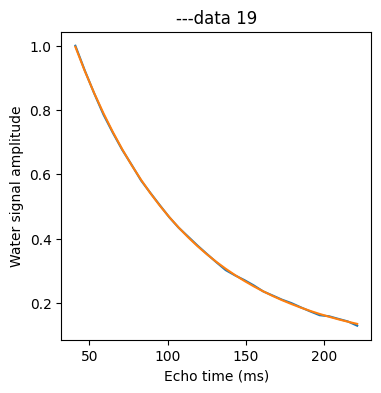

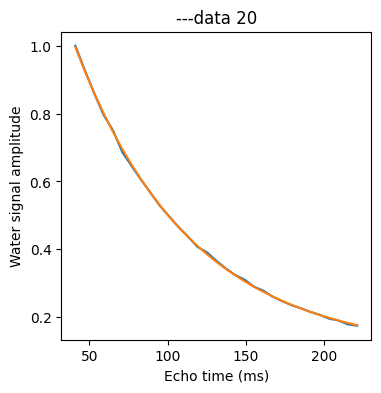

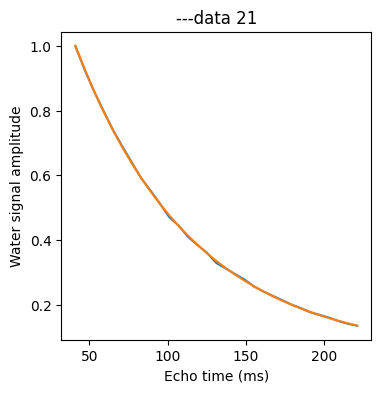

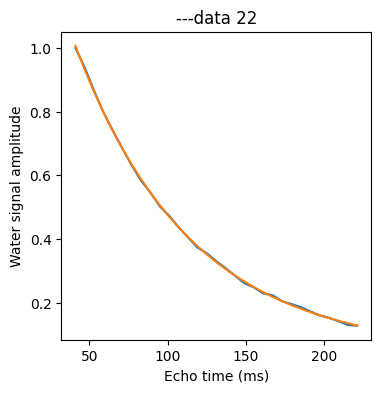

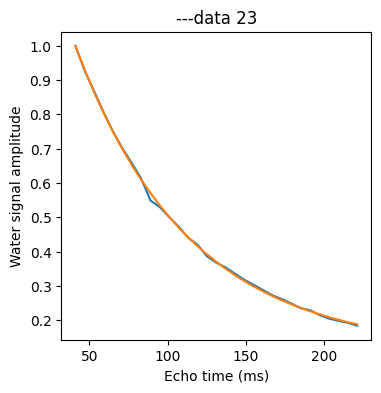

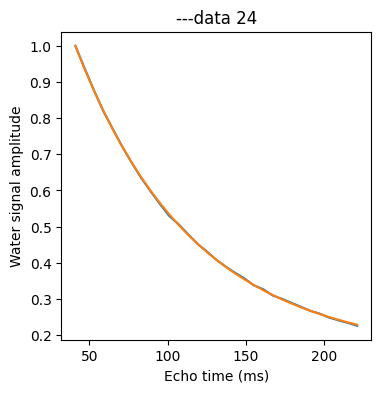

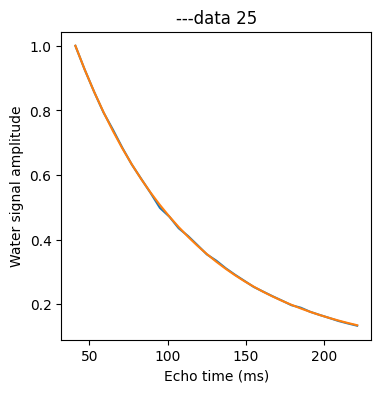

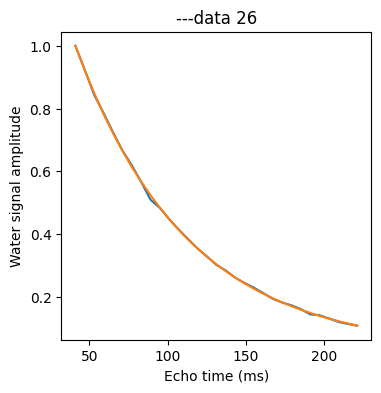

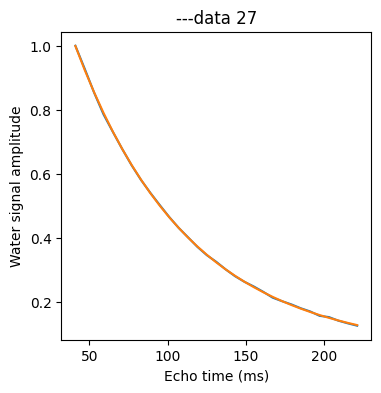

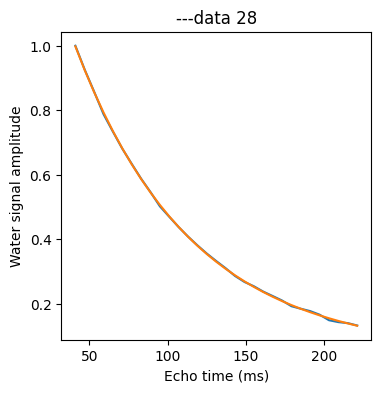

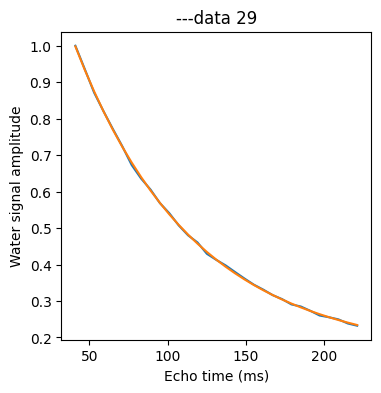

In [ ]:
# Read raw invivo datasets in NumPy arrays and perform scaling with water reference.
# Please see Eq.5 in Quantification of spatially localized MRS by a novel deep learning, Magn Reson Med. 2023; 90:1282-1296.

def get_scaling_factor(ref):

    c1 = (0.62*43300 + 0.27*35580)/(0.62+0.27) # 0.62:gray matter fraction, 0.27:white matter fraction
    c2 = 0.33 # the amplitude of simulated unsuppressed water reference at TE =0

    def fit_func(x, a, b, t2):
        return a*np.exp(-x/(80.0+t2)) + b*np.exp(-x/2000) # assuming CSF's T2 = 2000 ms

    ref = ref[1:, 0] + 1j*ref[1:, 1]   # remove the first echo and use only the remaining 31 echoes
    phase = ref/np.abs(ref)  # get the phase
    phase = phase.sum()/31

    x = [35.0+6.0+i*6 for i in range(31)]
    x = np.asarray(x)
    y = np.abs(ref)/np.abs(ref[0])

    p= curve_fit(fit_func, x,y)
    water_amplitude = p[0][0]*np.abs(ref[0])  # water reference amplitude at TE = 0
    c = c2/(2.0*water_amplitude)*c1   # 2.0 accounts for that the number of scans for the water reference is half of that for the spectral scans

    t2=p[0][2]+80
    fraction= p[0][1]/(p[0][0] + p[0][1])

    y1 = p[0][0]*np.exp(-x/(80.0+p[0][2])) + p[0][1]*np.exp(-x/2000)
    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.plot(x, y)
    ax.plot(x, y1)
    ax.set_xlabel('Echo time (ms)')
    ax.set_ylabel('Water signal amplitude')
    if i == 0:
      ax.set_title(f'Bi-exponential fit of water reference amplitude for data {i}')
    else:
      ax.set_title(f'---data {i}')
    return c, phase, t2, fraction


invivo_data=[]
z_data = np.load('numpy_data.npz')
references = z_data['arr_0']
datasets = z_data['arr_1']

for i in range(30):

    reference=references[i]
    reference = reference[:,0,:]
    data = datasets[i]

    scaling_factor, phase, _, _ = get_scaling_factor(reference)

    data = data[:,:,0] + 1j*data[:,:,1]
    data = data*scaling_factor*np.conj(phase) # phase corrected to get right spectrla phase for visualization in the frequency domain
    data = np.stack([data.real,data.imag], axis=-1)
    invivo_data.append(data)


invivo_data = np.asarray(invivo_data, dtype=np.float32)
np.save('invivo_data.npy', invivo_data)

In [ ]:
# deepJPRESS model testing on in vivo data
%%writefile tf_215.py
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1
EPOCHS = 20
SHUFFLE_SIZE= 4096
POINTS=2048

NUM_FID = 18
NUM_TARGET_FIDS = 14
NUM_TARGET_CONCS=13
TRAIN_DATA_SIZE =1024
LEARNING_RATE=5e-4

strategy = tf.distribute.get_strategy()
#print("REPLICAS: ", strategy.num_replicas_in_sync)

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.

    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def tf_serialize_invivo_example(sig):

    def serialize_invivo_example(sig):
        feature = {
        'invivo': _bytes_feature(tf.io.serialize_tensor(sig))
          }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    tf_string = tf.py_function(serialize_invivo_example,(sig,), tf.string)

    return tf.reshape(tf_string, ())

invivo_data = np.load('invivo_data.npy')
ds = tf.data.Dataset.from_tensor_slices((invivo_data,))
ds = ds.map(tf_serialize_invivo_example)

tf_filename = 'invivo_data.tfrec'
writer = tf.data.experimental.TFRecordWriter(tf_filename)
writer.write(ds)

def parse_invivo_record(example):
    feature_description = {
        'invivo': tf.io.FixedLenFeature([], tf.string, default_value='')
        }

    return tf.io.parse_single_example(example, feature_description)

def invivo_decode(features):
    signal = tf.io.parse_tensor(features['invivo'], tf.float32)
    signal = tf.reshape(signal, (32,2048,2))
    return {'input FID':signal}


def invivo_dataloader(invio_tfrecords):
    invivo_dataset=(
        tf.data.TFRecordDataset(invivo_tfrecords, num_parallel_reads=AUTO)
                    .map(parse_invivo_record, num_parallel_calls=AUTO)
                    .map(invivo_decode, num_parallel_calls=AUTO)
                    .batch(1)
                    .prefetch(AUTO)
                   )
    return invivo_dataset


def wavenet(x, filters, dilations=8, kernel_size=5):
    dilation_rates = [2**i for i in range(dilations)]
    x = L.Conv1D(filters = filters,
                            kernel_size = 1,
                            padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = L.Conv1D(filters = filters,
                      kernel_size = kernel_size,
                      padding = 'same',
                      activation = 'tanh',
                      dilation_rate = dilation_rate)(x)
        sigm_out = L.Conv1D(filters = filters,
                      kernel_size = kernel_size,
                      padding = 'same',
                      activation = 'sigmoid',
                      dilation_rate = dilation_rate)(x)
        x = L.Multiply()([tanh_out, sigm_out])

        x = L.Conv1D(filters = filters,   kernel_size = 1,padding = 'same')(x)

        res_x = L.Add()([res_x, x])

    return res_x


def deepJPRESS(dims, echoes=32, points=2048, dilation_depth=8,
               num_concentrations=NUM_TARGET_CONCS, num_fids=NUM_TARGET_FIDS):
          input = L.Input(shape=(echoes, points, 2), name='input FID')
          x = tf.reshape(input, (-1,points,2))
          x = x - tf.math.reduce_mean(x, axis=1, keepdims=True)

          #encoder block1
          x = wavenet(x,dims, dilation_depth)
          x = L.LayerNormalization(axis=-1)(x)
          wavenet_out = L.Activation('relu')(x)
          to_decoder1 = tf.stop_gradient(wavenet_out)

          #x = L.GlobalAveragePooling1D()(wavenet_out)
          x = wavenet_out[:,0:64,:]
          x = tf.reduce_mean(x, 1)

          x = tf.reshape(x,(-1,echoes, dims))
          x = L.Bidirectional(L.GRU(dims,return_sequences=True))(x)
          x = L.Conv1D(dims, kernel_size=1, padding='same', use_bias=False)(x)
          x = L.LayerNormalization(axis=-1)(x)
          x = L.Activation('relu')(x)
          x = tf.reshape(x, (-1, dims))
          x = L.RepeatVector(points)(x)
          x = tf.concat([wavenet_out, x],-1)


          #encoder block2
          x = wavenet(x, dims, dilation_depth)
          x = L.LayerNormalization(axis=-1)(x)
          wavenet_out = L.Activation('relu')(x)
          to_decoder2 = tf.stop_gradient(wavenet_out)

          #x = L.GlobalAveragePooling1D()(wavenet_out)
          x = wavenet_out[:,0:64,:]
          x = tf.reduce_mean(x, 1)

          x = tf.reshape(x,(-1,echoes, dims))
          x = L.Bidirectional(L.GRU(dims, return_sequences=True))(x)
          x = L.Conv1D(dims, kernel_size=1, padding='same', use_bias=False)(x)
          x = L.LayerNormalization(axis=-1)(x)
          x = L.Activation('relu')(x)
          x = tf.reshape(x, (-1, dims))
          x = L.RepeatVector(points)(x)
          x = tf.concat([wavenet_out, x],-1)

          #encoder block3
          x = wavenet(x, dims, dilation_depth)
          x = L.LayerNormalization(axis=-1)(x)
          wavenet_out = L.Activation('relu')(x)
          to_decoder3 = tf.stop_gradient(wavenet_out)

          #x = L.GlobalAveragePooling1D()(wavenet_out)
          x = wavenet_out[:,0:64,:]
          x = tf.reduce_mean(x, 1)

          x = tf.reshape(x,(-1,echoes, dims))
          x = L.Bidirectional(L.GRU(dims, return_sequences=True))(x)
          x = L.Conv1D(dims, kernel_size=1, padding='same', use_bias=False)(x)
          x = L.LayerNormalization(axis=-1)(x)
          x = L.Activation('relu')(x)
          x = tf.reshape(x, (-1, dims))
          x = L.RepeatVector(points)(x)
          x = tf.concat([wavenet_out, x],-1)

          #encoder block4
          x = wavenet(x, dims, dilation_depth)
          x = L.LayerNormalization(axis=-1)(x)
          wavenet_out = L.Activation('relu')(x)


          x = wavenet_out[:,0:64,:]
          x = tf.reduce_mean(x, 1)
          x = tf.reshape(x,(-1,echoes, dims))
          x = L.Bidirectional(L.GRU(dims,return_sequences=True))(x)
          x = L.Bidirectional(L.GRU(dims,return_sequences=True))(x)
          x = L.Conv1D(dims, kernel_size=1, padding='same', use_bias=False)(x)
          x = L.LayerNormalization(axis=-1)(x)
          x = L.Activation('relu')(x)

          fid_amplitude = L.Dense(num_concentrations, name='target_fid_amplitude')(x)
          features = L.GlobalAveragePooling1D()(x)
          concentrations = L.Dense(num_concentrations, name='concentration')(features)
          t2 = L.Dense(num_concentrations, name='t2')(features)


          #decoder
          x = tf.reshape(x, (-1, dims))
          x = L.RepeatVector(points)(x)
          x = tf.concat([x, wavenet_out, to_decoder3, to_decoder2, to_decoder1], -1)
          x = wavenet(x, dims, dilation_depth)
          x = L.LayerNormalization(axis=-1)(x)
          x = L.Activation('relu')(x)
          x = wavenet(x, dims, dilation_depth)

          #outputs of individual FIDs, total FIDs
          x = tf.reshape(x,(-1,echoes, points, dims))
          target_individual_signal = L.Dense(num_fids*2, name='target_individual_signal')(x)

          model = tf.keras.Model(inputs=input, outputs= [target_individual_signal, t2, concentrations, fid_amplitude])

          return model


replica_batch_size=BATCH_SIZE//strategy.num_replicas_in_sync

class OneCycleSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate, min_lr, batch_size, epochs, num_samples, warmup=0.2, hold=0.1):
        self.max_lr = learning_rate
        self.min_lr = min_lr
        self.batch_size = batch_size
        self.total_steps = 1.0*epochs*(num_samples//batch_size+1)
        self.warmup_steps = warmup*epochs*(num_samples//batch_size+1)
        self.hold_steps = hold*epochs*(num_samples//batch_size+1)
        self.decay_steps = self.total_steps - self.warmup_steps-self.hold_steps
    @tf.function
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        if step < self.warmup_steps:
            lr = self.max_lr*step/(self.warmup_steps+1.0)
        elif step < self.warmup_steps + self.hold_steps:
            lr = self.max_lr
        else:
            progress = (step-self.warmup_steps-self.hold_steps)/self.decay_steps
            lr = self.max_lr*0.5*(1.0 + tf.math.cos(math.pi*progress))

        return tf.math.maximum(lr, self.min_lr)

lr_scheduler = OneCycleSchedule(LEARNING_RATE, 1e-8, BATCH_SIZE, EPOCHS, TRAIN_DATA_SIZE)


def make_model(dims=128):

    K.clear_session()
    with strategy.scope():

        #[Water_fid, NAA_fid, Cr_fid, Cr2_fid, Cho_fid, mI_fid, Glu_fid, Gln_fid, GSH_fid, GABA_fid, Asp_fid, Tau_fid, Lac_fid, NAAG_fid, HG2_fid]
        def individual_signal_loss(y_true, y_pred):
          weight = tf.constant(2*[0.05]  +  2*(NUM_TARGET_FIDS-1)*[1.0])
          weight = tf.reshape(weight, (1,1,1,NUM_TARGET_FIDS*2))
          y_true  = y_true*weight
          y_pred = y_pred*weight
          y_true = tf.reshape(y_true, (y_true.shape[0], -1))
          y_pred = tf.reshape(y_pred, (y_true.shape[0], -1))
          sig_loss_replica = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
          return tf.reduce_sum(sig_loss_replica(y_true, y_pred))/replica_batch_size

        def t2_loss(y_true, y_pred):
          t2_loss_replica = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
          return tf.reduce_sum(t2_loss_replica(y_true, y_pred))/replica_batch_size

        def conc_loss(y_true, y_pred):
          weight = tf.constant([0.05] + (NUM_TARGET_CONCS-1)*[1.0])
          weight = tf.reshape(weight, (1,-1))

          y_true = weight*y_true
          y_pred = weight*y_pred
          y_pred = tf.clip_by_value(y_pred, 0, 1e5)

          met_loss_replica = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
          return tf.reduce_sum(met_loss_replica(y_true, y_pred))/replica_batch_size

        def fid_amplitude_loss(y_true, y_pred):
          weight = tf.constant([0.05] + (NUM_TARGET_CONCS-1)*[1.0])
          weight = tf.reshape(weight, (1,1,-1))

          y_true = weight*y_true
          y_pred = weight*y_pred
          y_pred = tf.clip_by_value(y_pred, 0, 1e5)

          loss_replica = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
          return tf.reduce_sum(loss_replica(y_true, y_pred))/replica_batch_size/32


        opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
        model =deepJPRESS(dims)
        model.compile(optimizer=opt, loss=[individual_signal_loss, t2_loss, conc_loss, fid_amplitude_loss],
                        loss_weights=[20.0, 1.0, 0.3, 0.1])

        return model

model = make_model()
num_invivo_samples=30

invivo_tfrecords = tf.io.gfile.glob('invivo_data.tfrec')
invivo_prediction_steps = num_invivo_samples//BATCH_SIZE
model.load_weights('fingerprint_model.h5')
predictions = model.predict(invivo_dataloader(invivo_tfrecords), verbose=1, steps=invivo_prediction_steps)
np.savez('predictions.npz', *predictions)

Overwriting tf_215.py


In [ ]:
# Run the model
!conda run -n py39 python tf_215.py
invivo_originals = np.load('invivo_data.npy')
predictions = np.load('predictions.npz')
predicted_signals = predictions['arr_0']
predicted_t2s = predictions['arr_1']
predicted_concs = predictions['arr_2']


30/30 [==============================] - 22s 492ms/step

2025-09-03 11:53:23.603725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-03 11:53:23.603775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-03 11:53:23.605291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 11:53:23.612456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler fl

In [ ]:
metabolites = ['tNAA', 'tCr', 'tCho', 'mI', 'Glu', 'Gln', 'GSH', 'GABA', 'Asp', 'Tau', 'Lac']
concentrations = pd.DataFrame(data=predicted_concs[:,1:-1], columns=metabolites).round(2)
concentrations

tNAA   tCr  tCho    mI    Glu   Gln   GSH  GABA   Asp   Tau   Lac
0    9.72  7.43  1.59  5.83   9.99  2.22  1.38  0.38  2.24  1.30  0.56
1    8.89  6.45  1.78  6.01   8.18  2.43  1.15  0.35  3.15  0.37  0.15
2   10.54  8.61  1.53  5.64  10.70  1.63  1.92  0.71  2.29  2.62  0.61
3   10.14  8.15  1.58  7.21   9.81  1.39  1.50  0.59  2.28  1.23  1.19
4    9.68  7.80  1.74  8.17  10.72  2.42  1.47  1.03  3.30  1.65  0.73
5   10.39  7.83  1.40  8.06  10.65  1.65  2.96  0.64  3.17  1.50  0.45
6    9.78  7.01  1.77  6.52  10.62  1.55  1.70  0.50  2.48  1.14  0.63
7   10.65  7.73  1.93  7.85  11.42  2.67  1.63  0.89  3.22  0.99  0.71
8    9.11  7.09  1.65  5.68   8.27  2.00  1.15  0.52  3.03  1.06  0.55
9    9.36  6.70  1.42  6.13   8.29  1.71  1.23  1.03  2.72  1.84  0.56
10   9.26  7.38  1.89  7.08   9.47  2.26  1.29  0.59  3.46  1.48  0.91
11  10.03  7.60  1.46  7.59  10.42  1.99  2.13  0.56  2.80  1.54  0.81
12   9.20  6.97  1.86  7.08   9.83  2.21  1.69  0.83  1.63  1.15  0.49
13   9.76  7.16  1.65  8.46   9.52  2.18  1.64  0.49  2.30  0.93  0.77
14  10.77  7.56  1.72  7.12  10.05  1.85  1.57  0.49  2.87  0.82  0.79
15  11.07  7.89  1.50  8.02  10.62  1.59  1.61  1.00  2.63  1.18  0.55
16  10.13  7.47  1.89  7.02   9.54  2.14  2.02  0.62  3.67  1.38  0.52
17   9.52  6.63  1.76  5.89  10.06  2.08  1.54  0.55  2.95  1.93  0.40
18  10.87  8.05  1.67  9.02  10.89  1.68  1.73  0.97  3.33  0.68  0.88
19   9.75  7.00  1.81  7.14  10.47  2.18  1.63  0.66  3.02  1.08  0.55
20  10.24  7.58  1.75  7.82  10.33  2.24  0.95  1.10  3.96  1.20  0.58
21  10.72  8.20  1.94  7.09  11.37  2.30  1.34  1.11  3.82  1.85  0.36
22  10.46  7.72  1.83  6.60  10.09  2.80  1.55  0.67  2.24  0.95  0.72
23   9.66  7.24  1.71  7.46   9.44  1.39  1.39  0.61  2.56  1.31  1.31
24   9.23  7.62  1.88  6.93  10.44  2.10  1.24  0.90  3.02  2.42  1.02
25  10.39  8.01  2.06  8.59  10.04  1.90  1.40  0.59  4.20  1.88  0.39
26  10.40  8.44  2.05  6.50  10.98  2.67  1.62  0.85  2.70  0.30  0.82
27   9.82  6.91  1.86  6.04  10.38  2.03  2.22  0.23  2.41  1.19  0.27
28  10.47  8.06  2.19  6.75  10.01  1.87  1.52  0.53  1.73  0.73  0.66
29   9.77  7.11  1.53  5.93  10.41  2.08  0.96  0.68  2.78  0.83  0.65

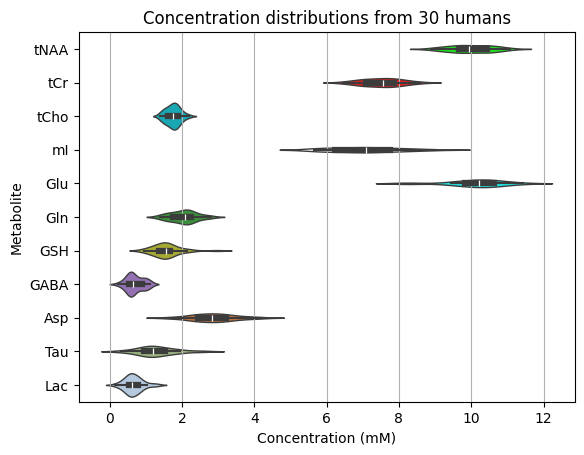

In [ ]:
df = concentrations.stack().to_frame(name='value').reset_index().rename(columns={'level_1':'Metabolite','value':'Concentration (mM)'})
colors=[(0.0, 1.0, 0.), (1.0, 0, 0), (0., 0.74, 0.8), (1., 1.0, 1.0),(0.0, 1.0, 1.0), (0.17, 0.62, 0.17),
        (0.73, 0.74, 0.13), (0.58, 0.40, 0.74), (0.83, 0.44, 0.156), (0.6, 0.73, 0.47), (0.68, 0.78, 0.90), (0.80, 0.42, 0.74)]

sns.violinplot(data=df, x='Concentration (mM)', y="Metabolite", palette=colors,linewidth=1, common_norm=True).set_title('Concentration distributions from 30 humans')
plt.grid(axis = 'x')
plt.show()

In [ ]:
#### T2 in unit ms ####
t2s = pd.DataFrame(data=1000*predicted_t2s[:,1:-1], columns=metabolites).astype(int)
t2s

tNAA  tCr  tCho   mI  Glu  Gln  GSH  GABA  Asp  Tau  Lac
0    255  211   243  283  195  184  224   244  204  270  256
1    235  196   222  248  187  170  208   214  187  235  230
2    228  193   219  249  179  168  205   218  187  241  232
3    260  213   242  284  198  183  222   240  204  269  255
4    270  221   256  296  204  191  233   247  211  277  263
5    231  186   210  237  176  163  185   197  176  229  219
6    262  214   246  284  199  185  224   241  204  271  255
7    241  198   229  257  186  173  204   215  188  246  236
8    236  192   221  248  184  168  205   215  184  239  230
9    231  191   218  247  181  167  201   216  187  240  230
10   241  196   227  252  186  168  208   217  188  241  233
11   252  205   235  270  190  180  209   226  195  257  243
12   265  213   247  278  200  179  219   248  206  268  252
13   260  210   242  278  195  180  219   236  201  263  251
14   245  202   233  263  187  175  210   224  192  251  238
15   228  190   213  245  180  167  196   206  180  234  225
16   286  236   274  316  218  201  249   266  223  297  280
17   257  208   238  274  193  181  216   232  199  263  249
18   219  188   212  240  173  165  191   199  176  229  221
19   253  206   239  272  194  180  215   229  196  260  246
20   246  205   240  266  193  176  219   226  196  252  244
21   235  201   216  243  185  164  204   219  194  228  225
22   256  212   242  282  198  183  228   243  204  268  256
23   245  199   231  256  186  171  205   223  191  246  233
24   247  208   244  267  192  174  218   239  199  252  244
25   248  203   234  263  188  176  209   218  190  251  238
26   247  213   242  278  194  183  220   236  201  263  252
27   259  207   236  275  194  182  213   233  197  265  249
28   255  210   236  276  199  179  217   234  199  260  246
29   255  205   245  262  191  177  214   241  201  255  242

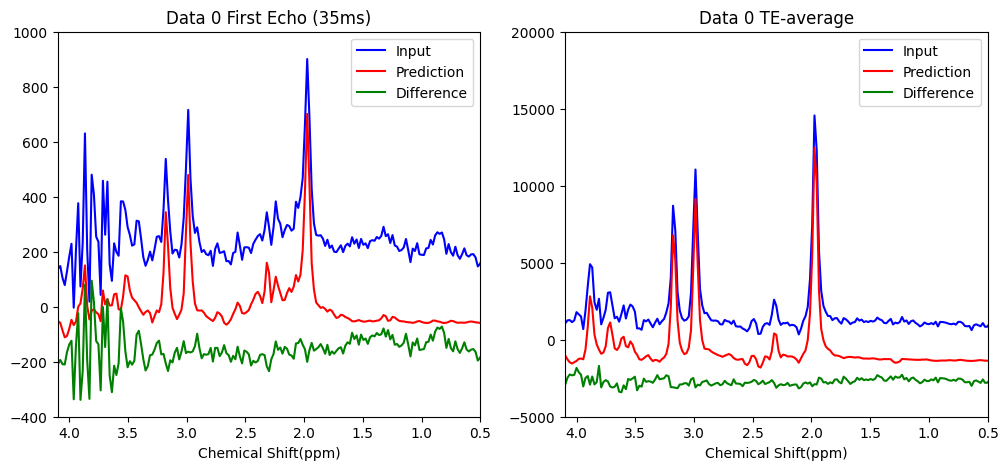

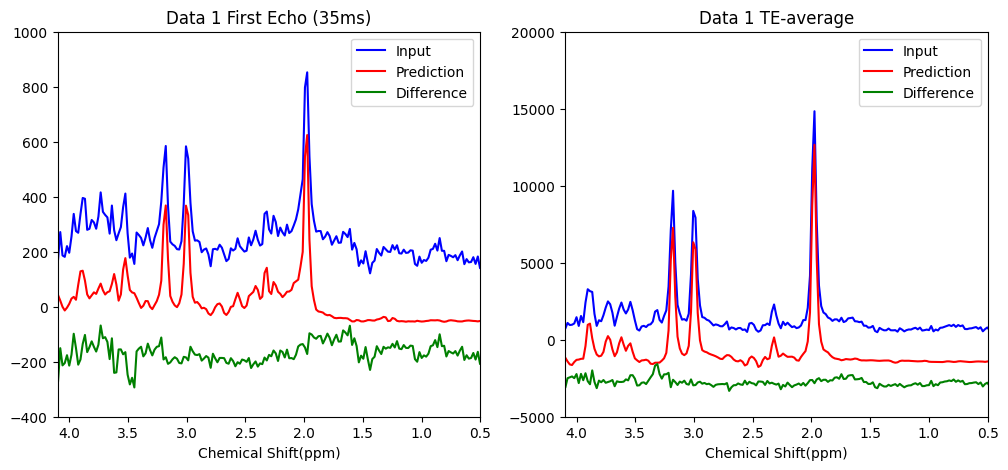

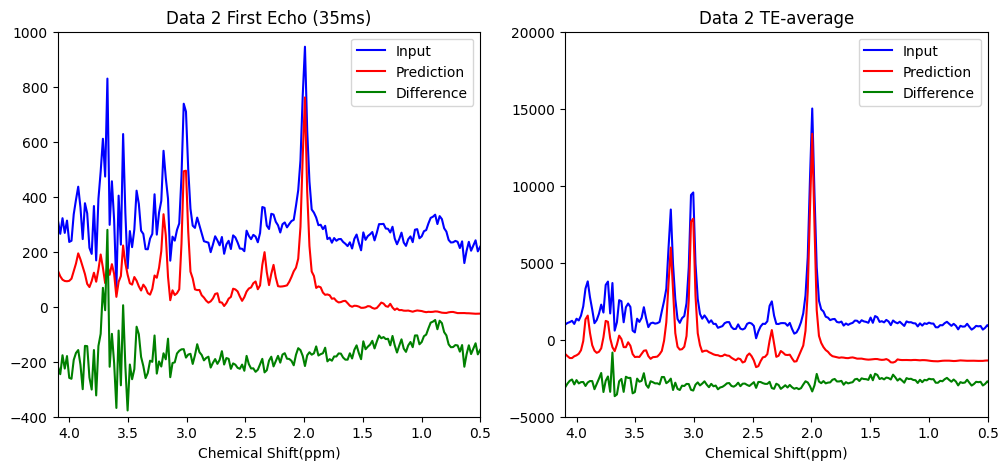

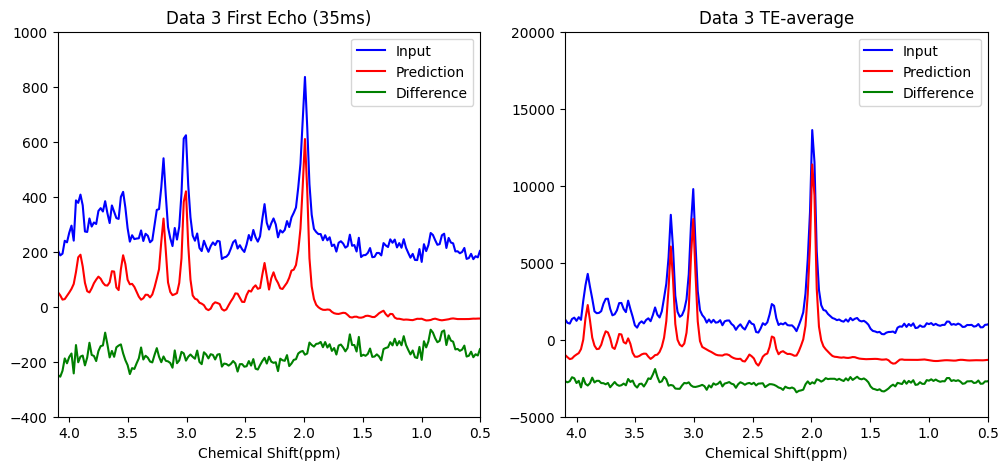

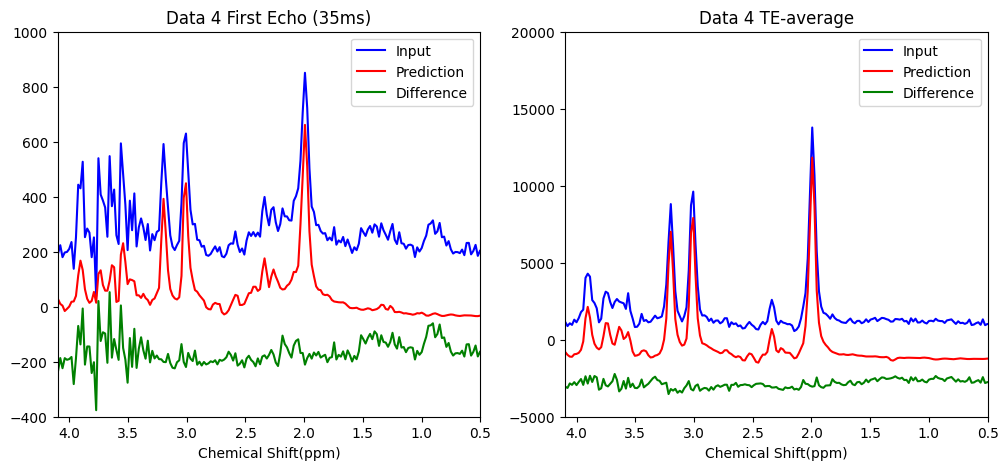

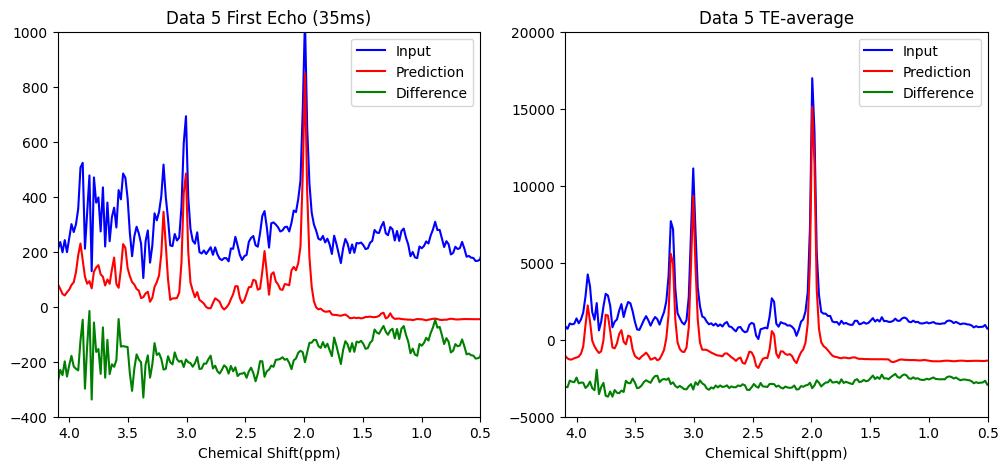

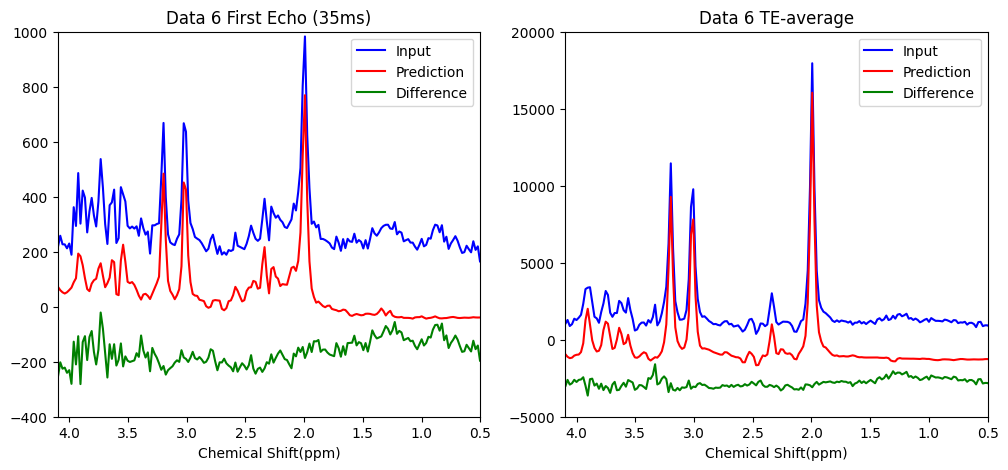

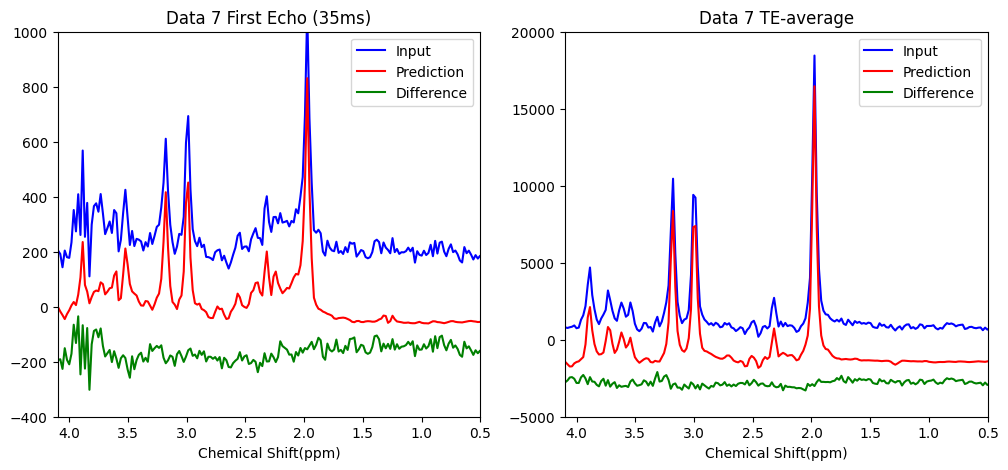

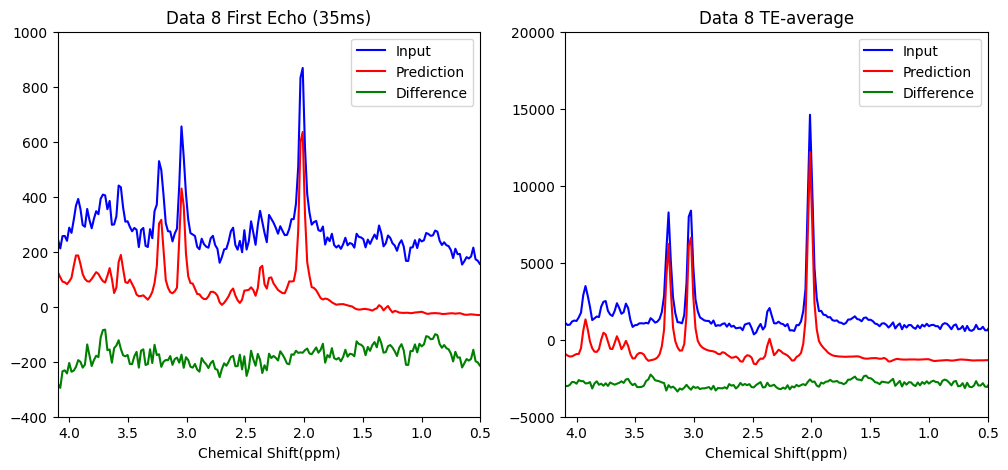

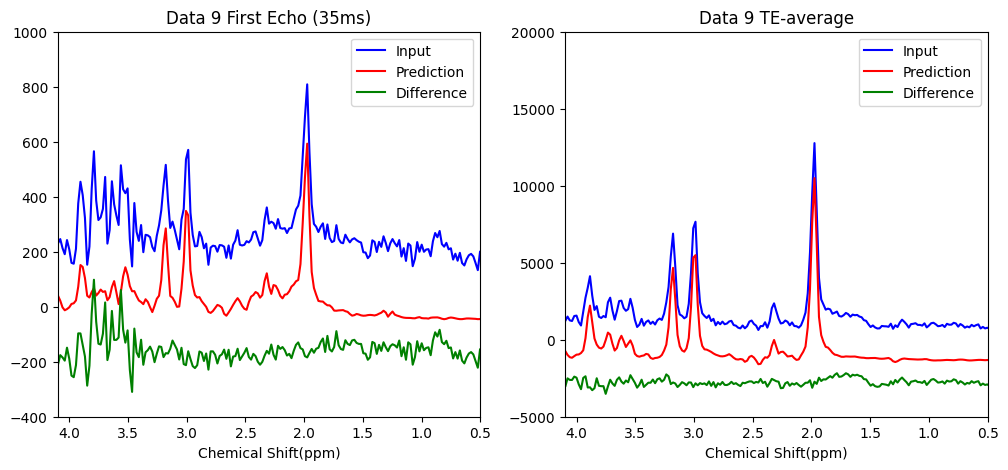

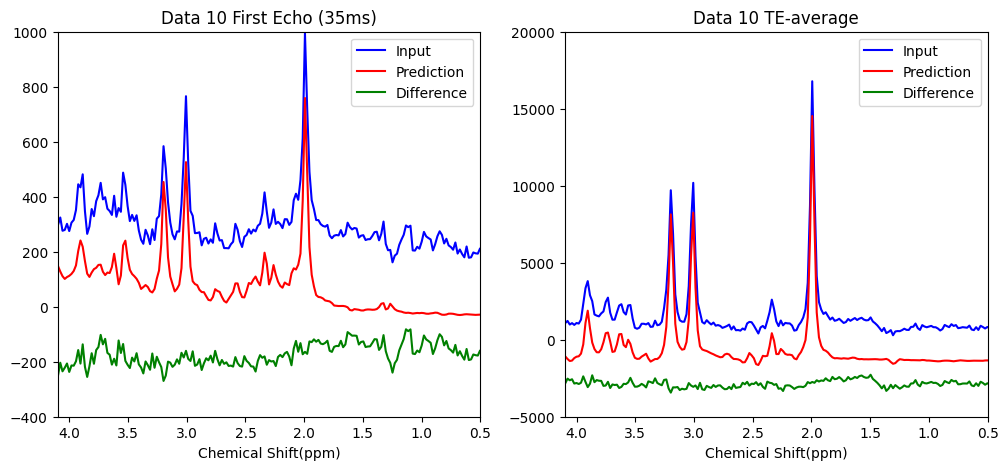

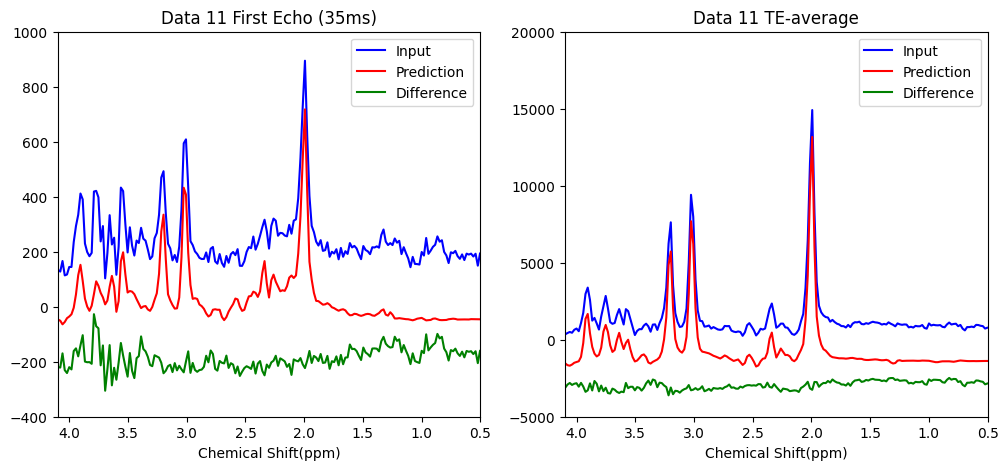

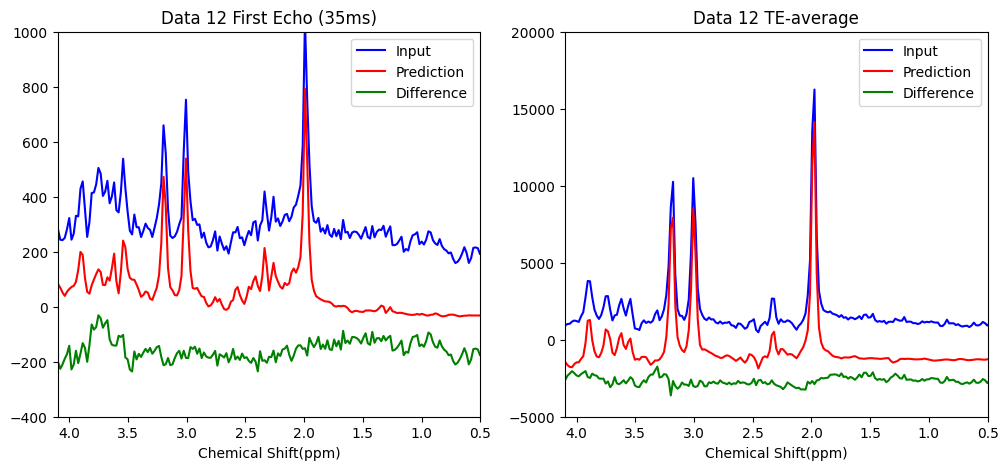

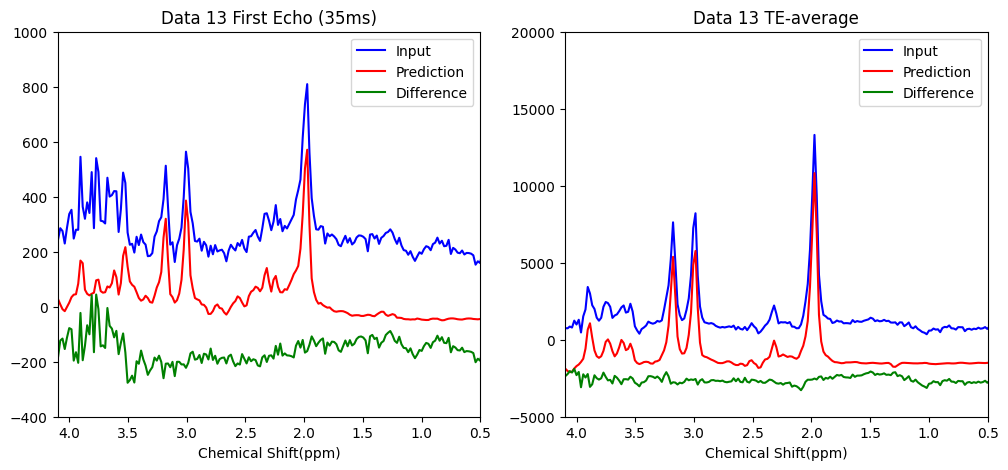

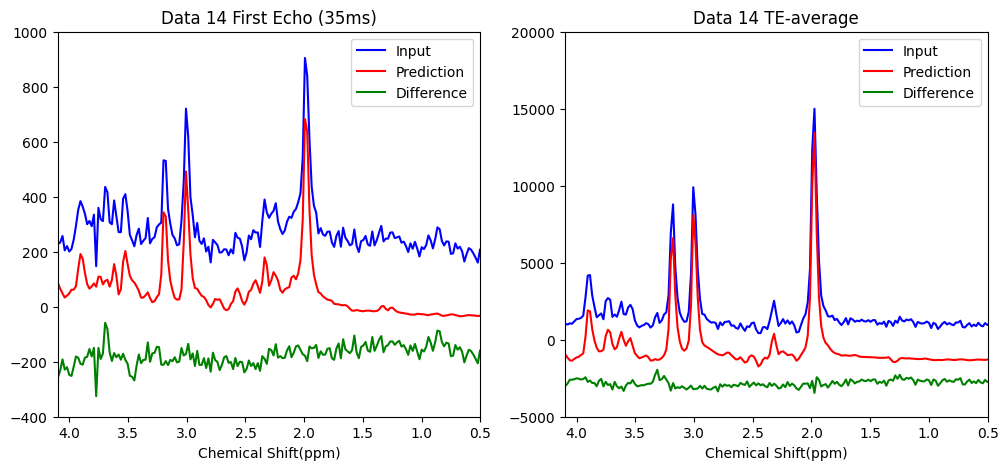

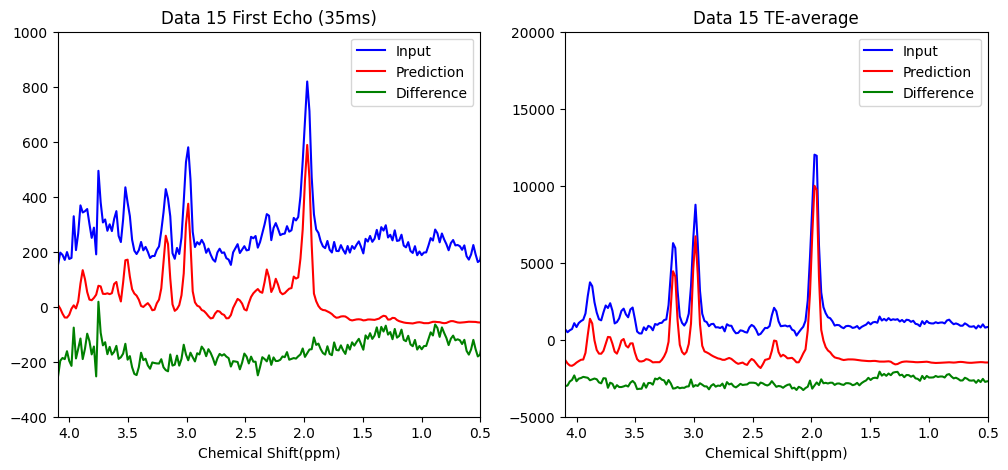

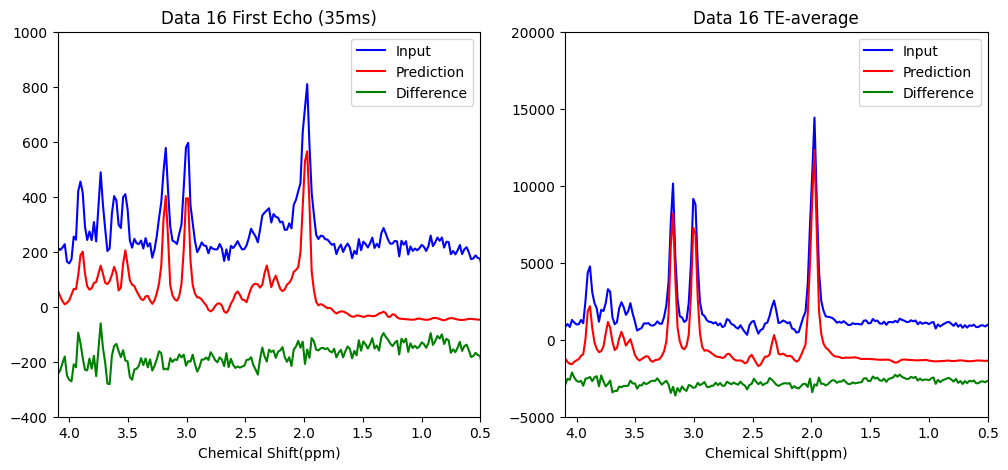

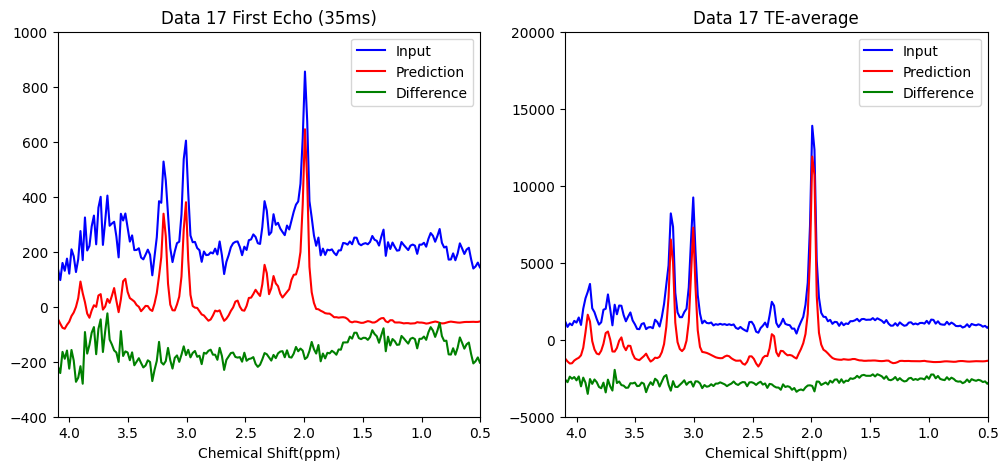

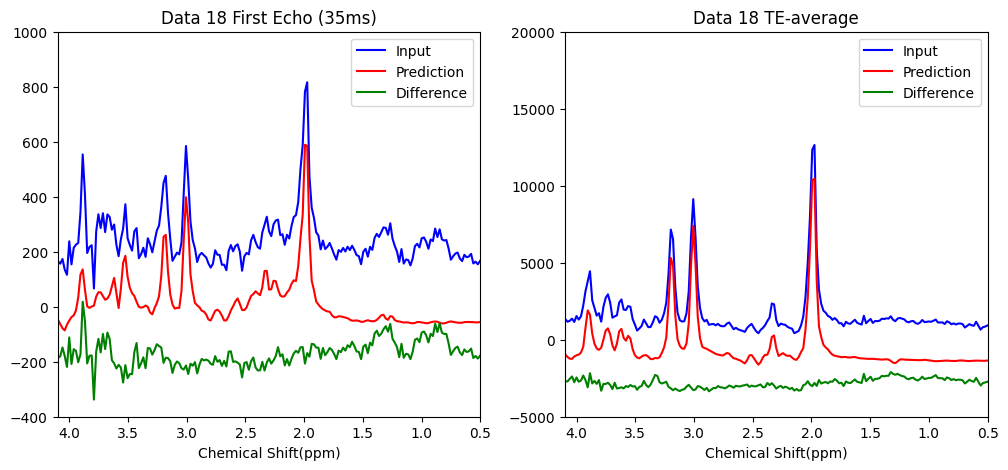

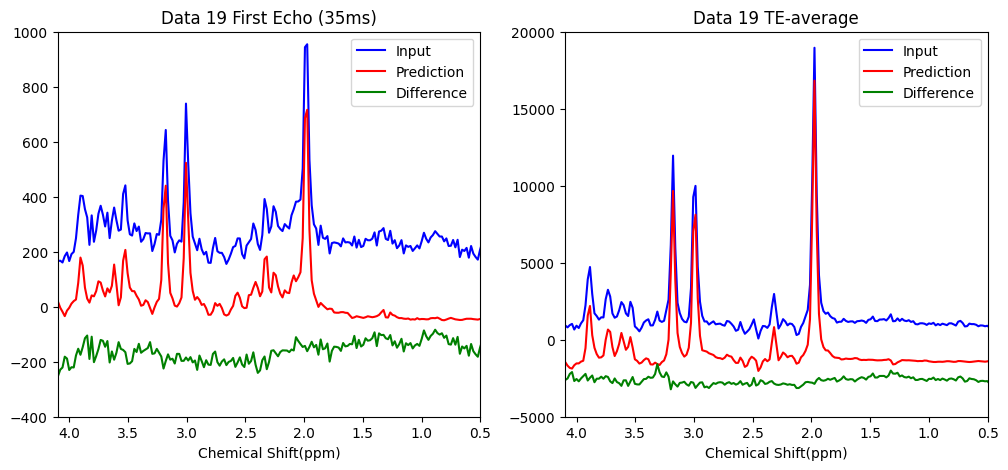

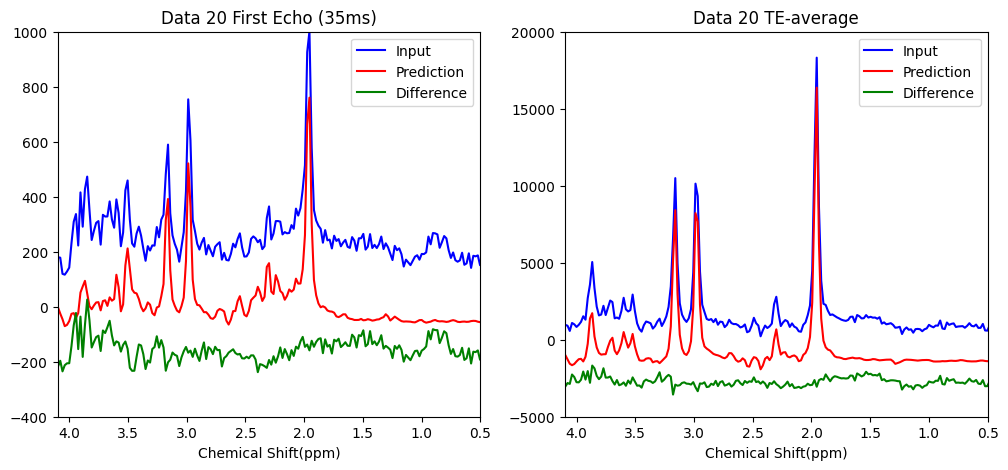

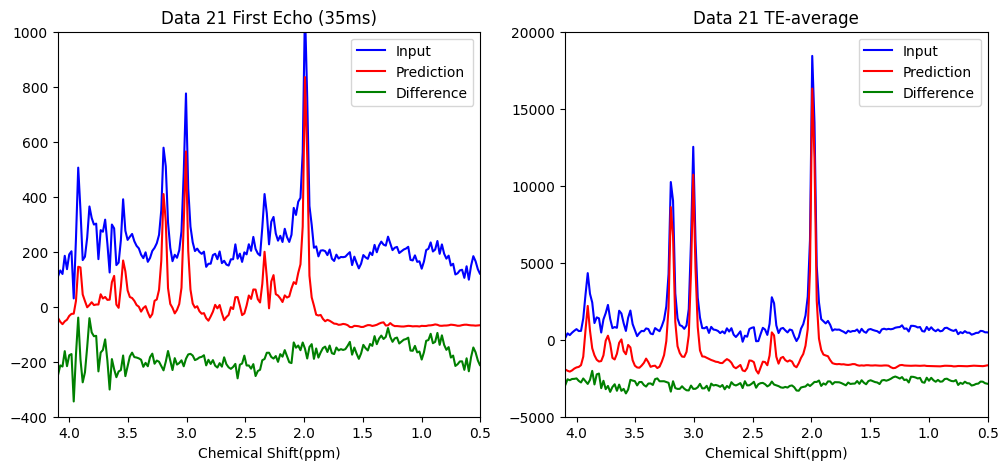

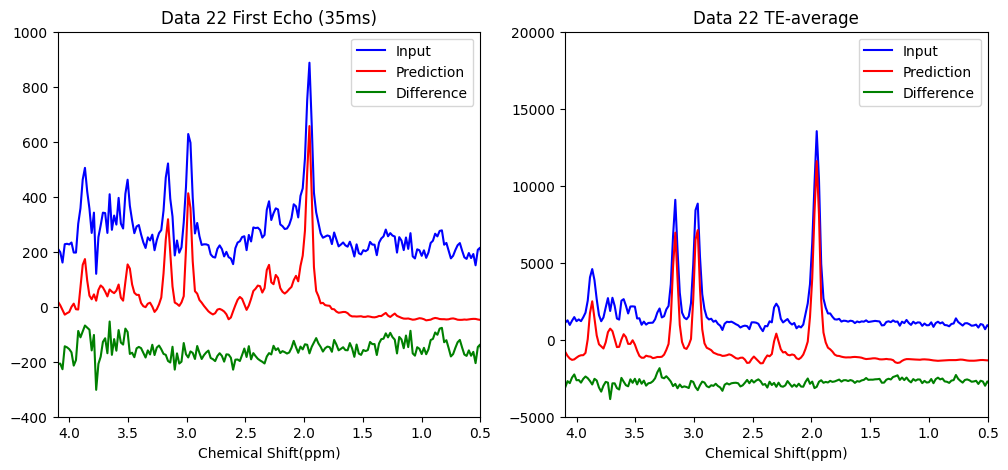

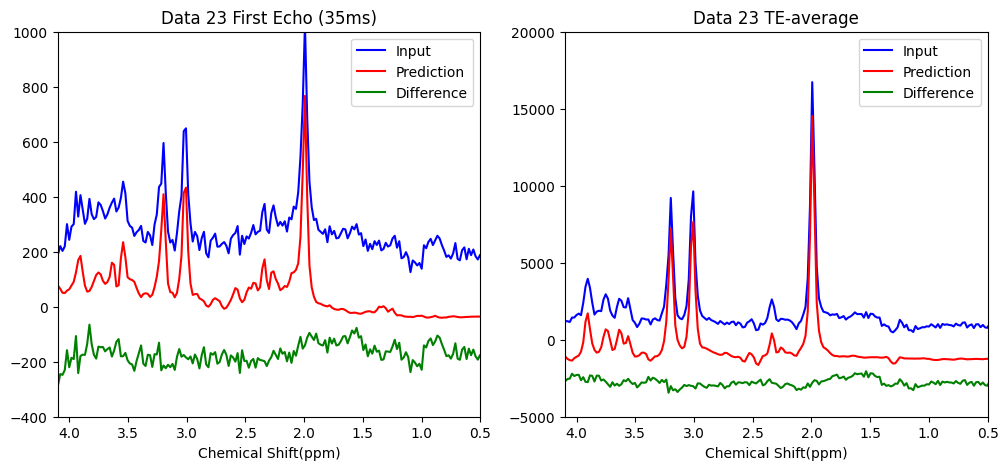

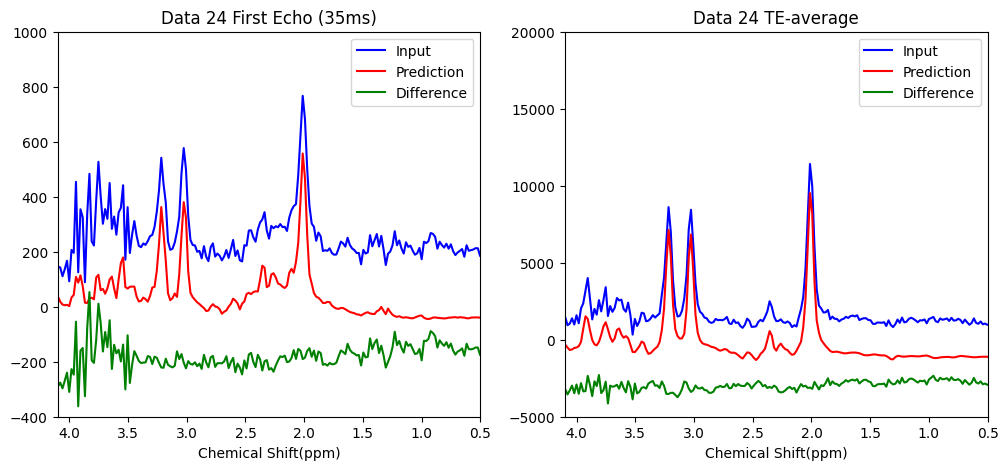

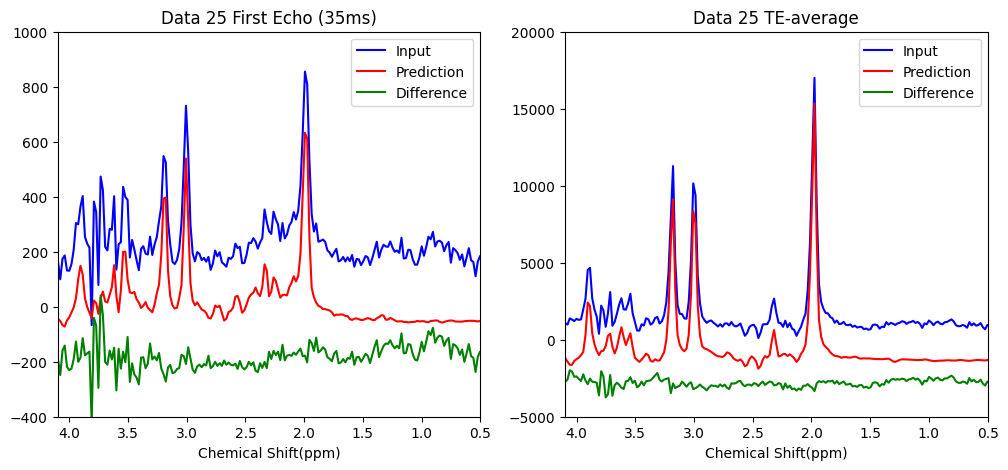

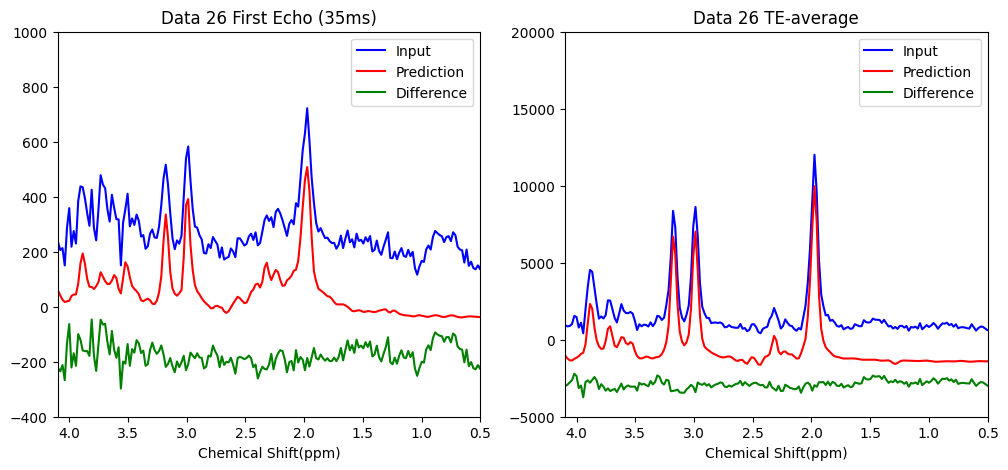

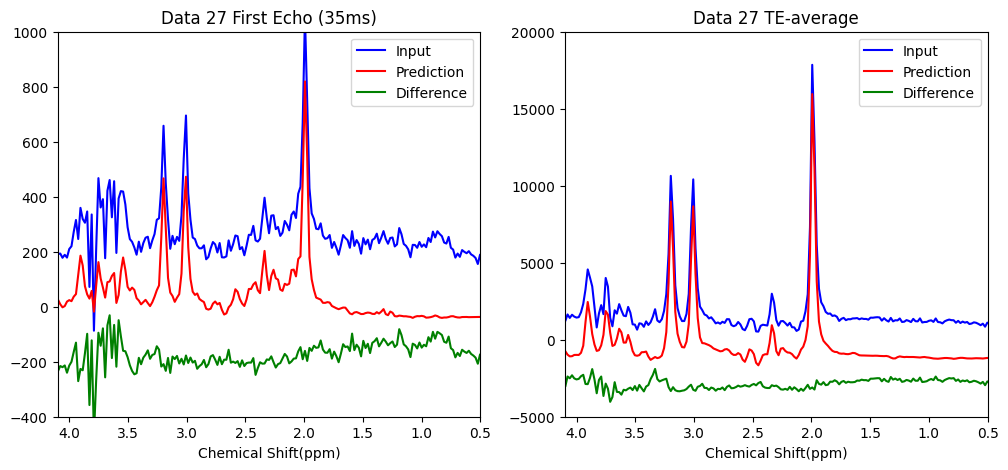

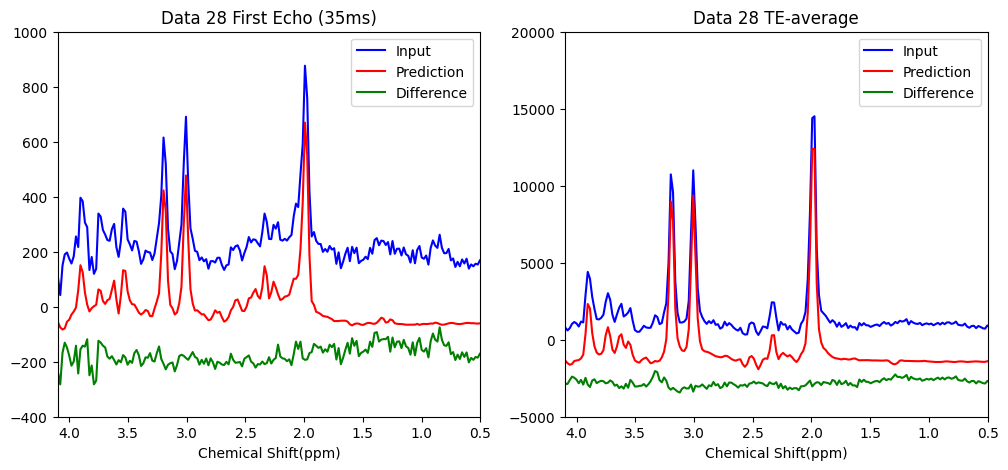

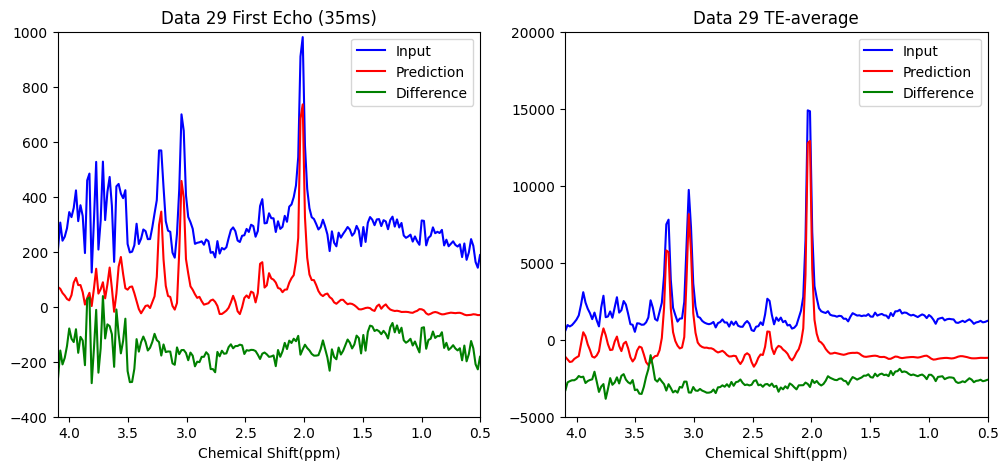

In [ ]:
####### Predicted Spectra #########
NUM_TARGET_FIDS = 14
def show_predictions(i):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5), sharey=False)

    data1 = invivo_originals[i][0]
    data1 = data1[:,0] + 1j*data1[:,1]

    data2 = predicted_signals[i][0]
    data2 = data2.reshape(2048, NUM_TARGET_FIDS, 2)
    data2 =data2.sum(1)
    data2 = data2[:,0] + 1j*data2[:,1]

    x = [1.0*(i-1024)*5000/(2048*127.7) + 4.67 for i in range(2048)]

    y1 = fftshift(fft(data1))
    y1 = [0.32*y1[2047-i].real +100 for i in range(2048)]
    y2 = fftshift(fft(data2))
    y2 = [0.32*y2[2047-i].real-100 for i in range(2048)]
    y3 = [y1[i]-y2[i] -400 for i in range(2048)]

    ax[0].set_xlim([4.1, 0.5])
    ax[0].set_ylim([-400,1000])
    ax[0].plot(x,y1, color='b')
    ax[0].plot(x,y2, color='r')
    ax[0].plot(x,y3, color='g')
    ax[0].set_xlabel('Chemical Shift(ppm)')
    ax[0].set_title(f'Data {i} First Echo (35ms)')
    ax[0].legend(['Input','Prediction','Difference'], loc='upper right')


    data1 = invivo_originals[i].sum(0)
    data1 = data1[:,0] + 1j*data1[:,1]

    data2 = predicted_signals[i].sum(0)
    data2 = data2.reshape(2048, NUM_TARGET_FIDS, 2)
    data2 =data2.sum(1)
    data2 = data2[:,0] + 1j*data2[:,1]

    y1 = fftshift(fft(data1))
    y1 = [0.32*y1[2047-i].real +100 for i in range(2048)]
    y2 = fftshift(fft(data2))
    y2 = [0.32*y2[2047-i].real-2000 for i in range(2048)]
    y3 = [y1[i]-y2[i] -5000 for i in range(2048)]

    ax[1].set_xlim([4.1, 0.5])
    ax[1].set_ylim([-5000,20000])
    ax[1].plot(x,y1, color='b')
    ax[1].plot(x,y2, color='r')
    ax[1].plot(x,y3, color='g')
    ax[1].set_xlabel('Chemical Shift(ppm)')
    ax[1].set_title(f'Data {i} TE-average')
    ax[1].legend(['Input','Prediction','Difference'], loc='upper right')

for i in range(30):
    show_predictions(i)